#Import Library

In [ ]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from gensim.models import Word2Vec
import re
import string

#Memuat Dataset

In [ ]:
# Memuat dataset
df = pd.read_csv('shopee_reviews_filtered.csv')

# Menampilkan informasi dasar dataset
print("Jumlah baris dan kolom:")
print(df.shape)

# Menampilkan tipe data dari setiap kolom
print("\nInformasi kolom:")
print(df.info())

# Menampilkan 5 baris pertama dataset
print("\n5 baris pertama dataset:")
print(df.head())

Jumlah baris dan kolom:
(4355, 3)

Informasi kolom:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4355 entries, 0 to 4354
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   username  4340 non-null   object
 1   rating    4355 non-null   int64 
 2   comment   4355 non-null   object
dtypes: int64(1), object(2)
memory usage: 102.2+ KB
None

5 baris pertama dataset:
          username  rating                                            comment
0  muhammadjuandra       5  Tampilan:ok banget cantik banget\nKualitas:ok ...
1   alvaro.maulana       5  Tampilan:Keren\nKualitas:bagus banget\nPerform...
2    nurhayati2607       5  Tampilan:Tampilan Bagus sekali, tidak tipis\nK...
3          i*****4       5  Kualitas:Bagus\nPerforma:Bagus\nTampilan:Bagus...
4     ziesuno70411       5  Tampilan:bagua sesuai foto\nPerforma:belum dip...


In [ ]:
# Cek nilai yang hilang
print("\nJumlah nilai yang hilang per kolom:")
print(df.isnull().sum())


Jumlah nilai yang hilang per kolom:
username    15
rating       0
comment      0
dtype: int64


In [ ]:
# Cek distribusi rating
print("\nDistribusi rating:")
print(df['rating'].value_counts())


Distribusi rating:
rating
5    2128
3     814
4     521
1     504
2     388
Name: count, dtype: int64


#Data Preprocessing

####Cek Data Missing

In [ ]:
# Menangani data yang hilang pada kolom 'username'
df_cleaned = df.dropna(subset=['username'])
print(df_cleaned.isnull().sum())

username    0
rating      0
comment     0
dtype: int64


####Text Cleaning

In [ ]:
# Fungsi untuk membersihkan teks
def clean_text(text):
    text = text.lower()
    text = re.sub(r'\d+', '', text)
    text = text.translate(str.maketrans('', '', string.punctuation))
    return text

df['cleaned_comment'] = df['comment'].apply(clean_text)

####Labeling Sentimen

In [ ]:
# Membuat label berdasarkan rating
df['label'] = df['rating'].apply(lambda x: 'positif' if x >= 4 else 'negatif')

# Menyeimbangkan dataset
sample_size = 1700
positif_df = df[df['label'] == 'positif'].sample(n=sample_size, random_state=42)
negatif_df = df[df['label'] == 'negatif'].sample(n=sample_size, random_state=42)

# Gabungkan kembali dataset yang seimbang
df_balanced = pd.concat([positif_df, negatif_df])

# Menampilkan beberapa data teratas untuk verifikasi
print(df_balanced.head())

                username  rating  \
1840  15.putri.mambrasar       4   
1237      nurmila_pamkas       5   
865              a*****i       5   
1622        cicinovita64       4   
1076    lasmifebrianti02       5   

                                                comment    label  
1840  Sdh lengkap bagus Tpi ngak ngerti sutilnya knp...  positif  
1237  Kualitas:bagus\n\nAlhamdulillah barang nyampe ...  positif  
865   Desain:bagus\nUkuran:pas untuk masak bertiga\n...  positif  
1622  Tampilan:ok\nKualitas:ya seperti panci masak\n...  positif  
1076  Desain:bagus\nUkuran:sesuai\nWarna:bagus\n\nTe...  positif  


#Data Preparation

In [ ]:
# Memisahkan fitur dan label
X = df['cleaned_comment'].values
y = df['label'].values

# Encode label (positif, negatif) ke dalam bentuk numerik
le = LabelEncoder()
y = le.fit_transform(y)
y = to_categorical(y, num_classes=2)

# Pembagian data menjadi training dan testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#Eksperimen dengan 3 Skema Pelatihan

####Skema 1: SVM dengan TF-IDF(80/20 split)

In [ ]:
# Vektorisasi data dengan TF-IDF
vectorizer = TfidfVectorizer()
X_tfidf = vectorizer.fit_transform(X)

# Split data menjadi training dan testing
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)

# Grid Search untuk optimasi parameter SVM
param_grid = {'C': [0.1, 1, 10], 'gamma': [0.001, 0.01, 0.1, 1]}
svm_model = SVC(kernel='linear')

grid_search = GridSearchCV(svm_model, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train.argmax(axis=1))

# Menampilkan hasil terbaik
print(f"Best SVM Parameters: {grid_search.best_params_}")
svm_accuracy = grid_search.score(X_test, y_test.argmax(axis=1))
print(f"Optimized SVM Accuracy: {svm_accuracy * 100:.2f}%")

Best SVM Parameters: {'C': 1, 'gamma': 0.001}
Optimized SVM Accuracy: 90.70%


####Skema 2: Random Forest dengan Word2Vec (80/20 split)

In [ ]:
# Tokenisasi teks
X_tokenized = [text.split() for text in X]

# Latih model Word2Vec
w2v_model = Word2Vec(sentences=X_tokenized, vector_size=100, window=5, min_count=1, workers=4)

# Fungsi untuk menghitung rata-rata vektor Word2Vec untuk satu dokumen
def vectorize_text(text_tokens, model, vector_size):
    vectors = [model.wv[token] for token in text_tokens if token in model.wv]
    if len(vectors) > 0:
        return np.mean(vectors, axis=0)
    else:
        return np.zeros(vector_size)

# Transformasi data menjadi representasi Word2Vec
X_w2v = np.array([vectorize_text(tokens, w2v_model, 100) for tokens in X_tokenized])

# Split data menjadi training dan testing
X_train_w2v, X_test_w2v, y_train, y_test = train_test_split(X_w2v, y, test_size=0.2, random_state=42)

# Hyperparameter tuning untuk Random Forest
param_grid = {'n_estimators': [100, 200], 'max_depth': [10, 20, 30], 'min_samples_split': [2, 5]}
rf_model = RandomForestClassifier()

grid_search_rf = GridSearchCV(rf_model, param_grid, cv=5, scoring='accuracy')
grid_search_rf.fit(X_train_w2v, y_train.argmax(axis=1))

# Evaluasi hasil
print(f"Best Random Forest Parameters: {grid_search_rf.best_params_}")
rf_accuracy = grid_search_rf.score(X_test_w2v, y_test.argmax(axis=1))
print(f"Optimized RF Accuracy: {rf_accuracy * 100:.2f}%")

Best Random Forest Parameters: {'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 200}
Optimized RF Accuracy: 82.78%


####Skema 3: Deep Learning LSTM (70/30 split)

In [ ]:
# Parameter
max_words = 10000
max_len = 100

# Tokenisasi teks
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(df['cleaned_comment'])

X_seq = tokenizer.texts_to_sequences(df['cleaned_comment'])
X_pad = pad_sequences(X_seq, maxlen=max_len)

# Gunakan label asli (positif/negatif)
X_train, X_test, y_train, y_test = train_test_split(X_pad, df['label'], test_size=0.3, random_state=42)

# Konversi label ke format numerik (0 dan 1) hanya untuk pelatihan
y_train_bin = (y_train == 'positif').astype(int)
y_test_bin = (y_test == 'positif').astype(int)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Bangun model LSTM dengan regularisasi
model = Sequential([
    Embedding(input_dim=max_words, output_dim=64, input_length=max_len),
    LSTM(64, return_sequences=True, kernel_regularizer='l2'),
    Dropout(0.4),
    LSTM(32, kernel_regularizer='l2'),
    Dropout(0.4),
    Dense(1, activation='sigmoid', kernel_regularizer='l2')
])

# Kompilasi model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Callback untuk Early Stopping dan Learning Rate Scheduler
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2)

# Pelatihan model
history = model.fit(
    X_train, y_train_bin,
    validation_data=(X_test, y_test_bin),
    epochs=20, batch_size=32,
    callbacks=[early_stopping, lr_scheduler]
)

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


96/96 ━━━━━━━━━━━━━━━━━━━━ 20s 147ms/step - accuracy: 0.6941 - loss: 1.8788 - val_accuracy: 0.8715 - val_loss: 0.6357 - learning_rate: 0.0010
Epoch 2/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 25s 197ms/step - accuracy: 0.8886 - loss: 0.5095 - val_accuracy: 0.8998 - val_loss: 0.3639 - learning_rate: 0.0010
Epoch 3/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 14s 146ms/step - accuracy: 0.9441 - loss: 0.2504 - val_accuracy: 0.8929 - val_loss: 0.3377 - learning_rate: 0.0010
Epoch 4/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 10s 106ms/step - accuracy: 0.9614 - loss: 0.1971 - val_accuracy: 0.9028 - val_loss: 0.3490 - learning_rate: 0.0010
Epoch 5/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 11s 117ms/step - accuracy: 0.9718 - loss: 0.1625 - val_accuracy: 0.8906 - val_loss: 0.3773 - learning_rate: 0.0010
Epoch 6/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 20s 116ms/step - accuracy: 0.9835 - loss: 0.1217 - val_accuracy: 0.8799 - val_loss: 0.3702 - learning_rate: 5.0000e-04


In [ ]:
# Evaluasi model
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int)

# Konversi prediksi ke format label string
predicted_labels = ['positif' if pred == 1 else 'negatif' for pred in y_pred]
accuracy = accuracy_score(y_test, predicted_labels)

print(f"LSTM Accuracy: {accuracy * 100:.2f}%")

41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step
LSTM Accuracy: 89.29%


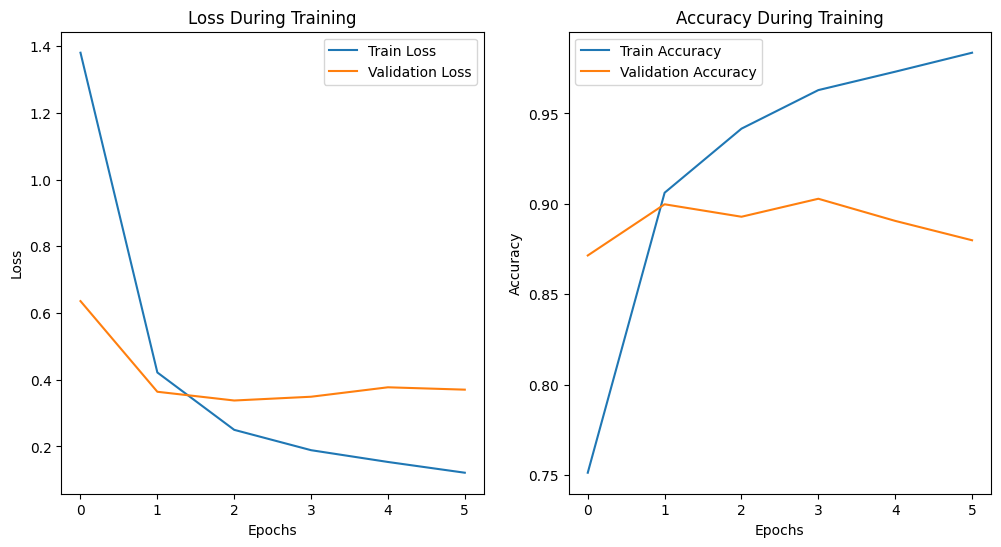

In [ ]:
# Visualisasi hasil
import matplotlib.pyplot as plt

# Plot loss dan akurasi selama pelatihan
plt.figure(figsize=(12, 6))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss During Training')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy During Training')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

#Testing

In [ ]:
# Bandingkan akurasi antara ketiga skema
accuracies = {
    'SVM': svm_accuracy,
    'Random Forest': rf_accuracy,
    'LSTM': accuracy
}

# Pilih model dengan akurasi tertinggi
best_model_name = max(accuracies, key=accuracies.get)
best_model_accuracy = accuracies[best_model_name]
print(f"Best Model: {best_model_name} with Accuracy: {best_model_accuracy * 100:.2f}%")

Best Model: SVM with Accuracy: 90.70%


In [ ]:
# Asumsi: Anda sudah memiliki model terbaik yang dipilih sebelumnya
if best_model_name == 'SVM':
    # Menggunakan model terbaik SVM
    final_model = grid_search.best_estimator_
    y_pred = final_model.predict(X_test)
    y_true = y_test.argmax(axis=1)

    # Mengubah label numerik ke string ('positif' atau 'negatif')
    y_pred_labels = ['positif' if pred == 1 else 'negatif' for pred in y_pred]
    y_true_labels = ['positif' if true == 1 else 'negatif' for true in y_true]

    # Tampilkan 10 contoh perbandingan antara label asli dan prediksi
    comparison = list(zip(y_true_labels, y_pred_labels))
    print(f"Perbandingan Label Asli dan Prediksi (SVM):")
    for i, (true, pred) in enumerate(comparison[:10]):
        print(f"Contoh {i+1}: Label Asli = {true}, Prediksi = {pred}")

elif best_model_name == 'Random Forest':
    # Menggunakan model terbaik Random Forest
    final_model = grid_search_rf.best_estimator_
    y_pred = final_model.predict(X_test_w2v)
    y_true = y_test.argmax(axis=1)

    # Mengubah label numerik ke string ('positif' atau 'negatif')
    y_pred_labels = ['positif' if pred == 1 else 'negatif' for pred in y_pred]
    y_true_labels = ['positif' if true == 1 else 'negatif' for true in y_true]

    # Tampilkan 10 contoh perbandingan antara label asli dan prediksi
    comparison = list(zip(y_true_labels, y_pred_labels))
    print(f"Perbandingan Label Asli dan Prediksi (Random Forest):")
    for i, (true, pred) in enumerate(comparison[:10]):
        print(f"Contoh {i+1}: Label Asli = {true}, Prediksi = {pred}")

elif best_model_name == 'LSTM':
    # Menggunakan model terbaik LSTM
    y_pred_prob = model.predict(X_test)
    y_pred = (y_pred_prob > 0.5).astype(int)
    y_true = y_test_bin

    # Mengubah label numerik ke string ('positif' atau 'negatif')
    y_pred_labels = ['positif' if pred == 1 else 'negatif' for pred in y_pred]
    y_true_labels = ['positif' if true == 1 else 'negatif' for true in y_true]

    # Tampilkan 10 contoh perbandingan antara label asli dan prediksi
    comparison = list(zip(y_true_labels, y_pred_labels))
    print(f"Perbandingan Label Asli dan Prediksi (LSTM):")
    for i, (true, pred) in enumerate(comparison[:10]):
        print(f"Contoh {i+1}: Label Asli = {true}, Prediksi = {pred}")


Perbandingan Label Asli dan Prediksi (SVM):
Contoh 1: Label Asli = positif, Prediksi = positif
Contoh 2: Label Asli = negatif, Prediksi = negatif
Contoh 3: Label Asli = positif, Prediksi = negatif
Contoh 4: Label Asli = negatif, Prediksi = negatif
Contoh 5: Label Asli = positif, Prediksi = positif
Contoh 6: Label Asli = positif, Prediksi = positif
Contoh 7: Label Asli = positif, Prediksi = positif
Contoh 8: Label Asli = positif, Prediksi = positif
Contoh 9: Label Asli = positif, Prediksi = positif
Contoh 10: Label Asli = positif, Prediksi = positif
